# Ex1:
* Read image as numpy array and flatten it
* change hyperparameter of autoencoder
* get nothing(even in niter=2000)
# Ex2:
```python
    epsilon = tf.random_uniform(shape=[self.batch_size,1], minval=0., maxval=1)
    x_hat = epsilon * inputs + (1 - epsilon) * self.G
    d_hat = self.discriminator(x_hat, reuse=True)[0]
    ddx = tf.gradients(d_hat, x_hat)[0]
    ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=1))
    ddx = tf.reduce_mean(tf.square(ddx - 1.0) * 10)
    
    self.d_loss = self.d_loss + ddx
```
* and cannot fix data shape

In [1]:
# Import libraries
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.contrib import learn
from tqdm import trange
from time import time
from Autoencoder.utils import *

(328, 120000)


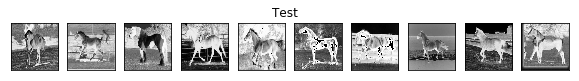

In [2]:
import cv2
num_training = 258
num_validation = 23
num_test = 47
# print(len(f))


f=[]
for root,dirs,files in os.walk("./gray"):
    for file in files:
        f.append(root+"/"+file)
# print(f[0])

all_images = np.zeros((len(f),200*200*3), dtype=np.float32)
for idx,_ in enumerate(f):
    img = cv2.imread(_)
#     print(img.shape)
#     print(type(img))
    img = cv2.resize(img,(200,200))
    img = img.flatten()
#     print(img.shape)
    all_images[idx] = img
# print(all_images.shape)
np.random.shuffle(all_images)
# print(all_images.shape)
mask = range(num_training)
train_images = all_images[mask]

mask = range(num_training, num_training + num_validation)
validation_images = all_images[mask]
mask = range(num_training + num_validation, num_training + num_validation + num_test)
test_images = all_images[mask]

# zmnist = learn.datasets.load_dataset("mnist")
# print((zmnist.train.images))
print(all_images.shape)
test_plot = all_images.reshape(-1, 200, 200,3)
plot_imgs(test_plot, n=10, title='Test')

In [3]:
class AutoEncoder(object):
    def __init__(self, sess, inputs, targets = None, 
                 b1 = 0.5, lr = 1., nf = 16, code_size = 16, 
                 nbatch = 64, niter = 200,
                 cost_function = 'bce', name = 'autoencoder', optimizer = 'adadelta'):
        self.sess = sess
        self.b1 = b1
        self.lr = lr
        self.nf = nf
        self.niter = niter
        self.nbatch = nbatch
        self.inputs = inputs
        self.code_size = code_size
        self.load_dataset()
        if targets is not None:
            self.targets = targets
            self.gen_noisy_data()
        else:
            self.targets = inputs
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.log = {'train_loss':[], 'valid_loss':[]}
        
        self.name = name
        

        self.build_model()
    def build_model(self):
        nf = self.nf
        code_size = self.code_size
        with tf.variable_scope(self.name) as scope:
            self.enc = tf.layers.dense(inputs=self.inputs, units = nf * 16, activation=tf.nn.relu, name='enc')
            self.enc2 = tf.layers.dense(inputs=self.enc, units = nf * 8, activation=tf.nn.relu, name='enc2')
            self.enc3 = tf.layers.dense(inputs=self.enc2, units = nf * 4, activation=tf.nn.relu, name='enc3')
            self.code = tf.layers.dense(inputs=self.enc3, units = code_size, activation=tf.nn.relu, name='code')

            self.dec = tf.layers.dense(inputs=self.code, units = nf * 4, activation=tf.nn.relu, name = 'dec')
            self.dec2 = tf.layers.dense(inputs=self.dec, units = nf * 8, activation=tf.nn.relu, name = 'dec2')
            self.dec3 = tf.layers.dense(inputs=self.dec, units = nf * 16, activation=tf.nn.relu, name = 'dec3')
            self.recon_logits = tf.layers.dense(inputs=self.dec, units =  200*200*3, name = 'recon_logits')
            print("jacob start")
            self.jacobian_op = self.jacobian(self.code, self.inputs)
            print("jacob end")
            if self.cost_function == 'mse':
                self.recon = self.recon_logits
                self.cost = tf.reduce_mean(tf.pow(self.targets - self.recon_logits, 2))
            elif self.cost_function == 'bce':
                self.recon = tf.nn.sigmoid(self.recon_logits)
                self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                                labels = self.targets, 
                                                                logits = self.recon_logits))
                
            
            else:
                raise NotImplementedError
    def train(self):
        if self.optimizer == 'adadelta':
            self.optim = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
        elif self.optimizer == 'adam':
            self.optim = tf.train.AdamOptimizer(self.lr, beta1=self.b1).minimize(self.cost)
        elif self.optimizer == 'rmsprop':
            self.optim = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
        else:
            raise NotImplementedError
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
                    
        X = self.inputs
        t0 = time()
        if self.targets is not self.inputs:
            print('Denoising autoencoder')
            Y = self.targets
            for epoch in trange(self.niter):
                t = time()
                shuffle(self.trX, self.trX_noisy)
                for batch, noisy_batch in iter_data(self.trX, self.trX_noisy, size = self.nbatch):
                    self.optim.run(session = self.sess, feed_dict={X: noisy_batch, Y: batch})

                idxs = np.random.randint(low = 0, high = len(self.vaX), size = self.nbatch)
                valid_batch = self.vaX[idxs]
                valid_noisy_batch = self.vaX_noisy[idxs]

                self.log['train_loss'].append(self.cost.eval(session = self.sess, 
                                                             feed_dict = {X:noisy_batch, 
                                                                          Y:batch})
                                             )
                self.log['valid_loss'].append(self.cost.eval(session = self.sess, 
                                                             feed_dict = {X:valid_noisy_batch, 
                                                                          Y: valid_batch})
                                             )
            print("final loss %g, total cost time: %.2fs" % (self.cost.eval(session = self.sess, 
                                                                            feed_dict={X: self.teX_noisy, 
                                                                                       Y: self.teX}), 
                                                             time() - t0))
            
        else:
            print('Audoencoder')
            for epoch in trange(self.niter):
                t = time()
                shuffle(self.trX)
                for batch in iter_data(self.trX, size = self.nbatch):
                    self.optim.run(session = self.sess, feed_dict={X: batch})

                idxs = np.random.randint(low = 0, high = len(self.vaX), size = self.nbatch)
                valid_batch = self.vaX[idxs]

                self.log['train_loss'].append(self.cost.eval(session = self.sess, feed_dict = {X:batch}))
                self.log['valid_loss'].append(self.cost.eval(session = self.sess, feed_dict = {X:valid_batch}))
            print("final loss %g, total cost time: %.2fs" % (self.cost.eval(session = self.sess, feed_dict={X: self.teX}), time() - t0))
        
    def load_dataset(self):
        self.trX = train_images # Returns np.array
        self.vaX = validation_images # Returns np.array
        self.teX = test_images
        
    def gen_noisy_data(self):
        # Noise scale
        noise_factor = 0.4
        trX_noisy = self.trX + noise_factor * np.random.normal(loc=0., scale=1.0, size=self.trX.shape) 
        vaX_noisy = self.vaX + noise_factor * np.random.normal(loc=0., scale=1.0, size=self.vaX.shape) 
        teX_noisy = self.teX + noise_factor * np.random.normal(loc=0., scale=1.0, size=self.teX.shape) 

        # Range of our dataset is [0,1]
        self.trX_noisy = np.clip(trX_noisy, 0., 1.)
        self.vaX_noisy = np.clip(vaX_noisy, 0., 1.)
        self.teX_noisy = np.clip(teX_noisy, 0., 1.)
        
    def encode(self, inputs):
        
        return self.code.eval(session = self.sess, feed_dict={self.inputs : inputs})
    def reconstruct(self, inputs):
        return self.recon.eval(session = self.sess, feed_dict={self.inputs : inputs})
    
    
    def jacobian(self, y, x):
        # For function f: mapping from single column x to multiple values ys
        # Note: tf.gradients returns sum(dy/dx) for each x in xs, so we need to compute each y seperatedly. 
        print(y.shape,x.shape)
        jacobian_flat = tf.concat(
          [tf.gradients(y_i, x)[0] for y_i in tf.unstack(y, axis = 1)], axis = 0)
        print(jacobian_flat.shape)
        return jacobian_flat
    
    def get_jaco_matrix(self, xbatch):
        jaco_matrix = []
        for x in xbatch:
            jaco_matrix.append(self.jacobian_op.eval(session = self.sess, feed_dict={self.inputs: x.reshape(1,-1)}).reshape(1,self.code_size,200*200*3))
        return np.concatenate(jaco_matrix)
                    
        
        

In [4]:
sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 200 * 200 * 3])
autoencoder = AutoEncoder(sess=sess, inputs=X, optimizer='adadelta', lr=1)

jacob start
(?, 16) (?, 120000)
(?, 120000)
jacob end


In [6]:
# sess.close()
# tf.reset_default_graph()

In [7]:
autoencoder.train()

Audoencoder


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.84it/s]


final loss -4.72643e+31, total cost time: 51.57s


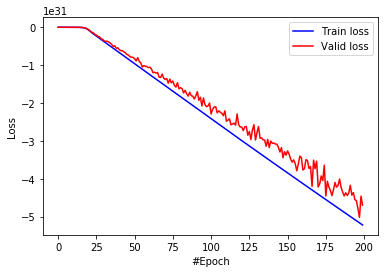

In [8]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

(10, 120000)
(10, 200, 200, 3)


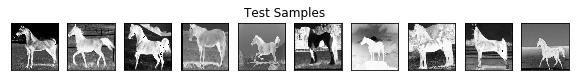

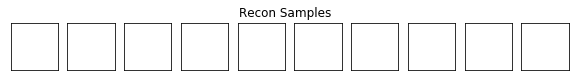

In [9]:
n = 10
print(autoencoder.teX[:n].shape)
orig_imgs = autoencoder.teX[:n].reshape(-1, 200, 200,3)
print(orig_imgs.shape)
recon_imgs = autoencoder.reconstruct(
  autoencoder.teX[:n]).reshape(-1, 200, 200,3)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

In [11]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 200 * 200*3])
Y = tf.placeholder(tf.float32, shape=[None, 200 * 200*3])

# In our AutoEncoder class,
# it will automatically change to denoising autoencoder if "targets" is given.
autoencoder = AutoEncoder(
    sess=sess, inputs=X, targets=Y, optimizer='adadelta', lr=1)
# autoencoderModel = AutoEncoder(
#     sess=sess, inputs=X, optimizer='adam', niter=200, cost_function='mse')
autoencoder.train()

jacob start
(?, 16) (?, 120000)
(?, 120000)
jacob end
Denoising autoencoder


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:53<00:00,  1.75it/s]


final loss -1.84747e+32, total cost time: 113.74s


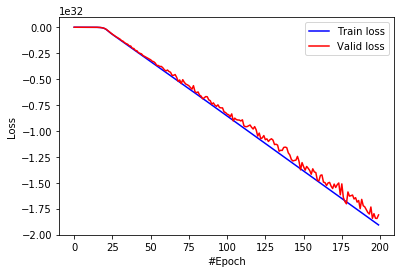

In [12]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

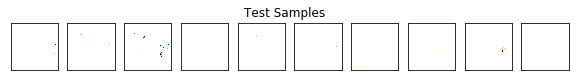

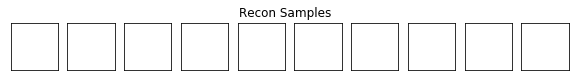

In [14]:
n = 10

orig_imgs = autoencoder.teX_noisy[:n].reshape(-1, 200, 200,3)
recon_imgs = autoencoder.reconstruct(
  autoencoder.teX_noisy[:n]).reshape(-1, 200, 200,3)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

In [15]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

In [16]:
class DCGAN(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=128,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):
    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(
        bce(self.D_logits_real, tf.ones_like(self.D)))
    self.d_loss_fake = tf.reduce_mean(
        bce(self.D_logits_fake, tf.zeros_like(self.D_)))
    self.g_loss = tf.reduce_mean(bce(self.D_logits_fake, tf.ones_like(self.D_)))

    self.d_loss = self.d_loss_real + self.d_loss_fake

    t_vars = tf.trainable_variables()
    # get variables for generator and discriminator,
    # since they are trained separately.
    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]

    self.saver = tf.train.Saver()

  def train(self):
    #get the optimization ops
    d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.g_loss, var_list=self.g_vars)
    init = tf.global_variables_initializer()
    self.sess.run(init)

    #generate random noise
    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    start_time = time.time()
    print('start training')
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % 2 == 0:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      # calculate the loss to monitor the training process
      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      # save the generated samples
      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image

      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(bn(conv2d(h0, self.df_dim, name='d_h1_conv')))
      h1 = flatten(h1)
      h2 = lrelu(bn(linear(h1, self.dfc_dim, 'd_h2_lin')))
      h3 = linear(h2, 1, 'd_h3_lin')

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(bn(linear(z, self.gfc_dim, 'g_h0_lin')))

      h1 = tf.nn.relu(bn(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin')))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(bn(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2')))
      return tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

In [ ]:
# import imageio
# imageio.plugins.ffmpeg.download()

In [ ]:
# tf.reset_default_graph()
# sess.close()

In [17]:
#Inherit from DCGAN class
class IWGAN(DCGAN):

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    
    #IWGAN
    epsilon = tf.random_uniform(shape=[self.batch_size,1], minval=0., maxval=1)
    x_hat = epsilon * inputs + (1 - epsilon) * self.G
    d_hat = self.discriminator(x_hat, reuse=True)[0]
    print((d_hat),type(x_hat))
    ddx = tf.gradients(d_hat, x_hat)[0]
    print(ddx.get_shape().as_list())
    ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=1))
    ddx = tf.reduce_mean(tf.square(ddx - 1.0) * 10)
    
    self.d_loss = self.d_loss + ddx
    
    self.saver = tf.train.Saver()

  def train(self):
    g_optim = tf.train.AdamOptimizer(learning_rate=1e-4,beta1=0.5,beta2=0.9).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.AdamOptimizer(learning_rate=1e-4,beta1=0.5,beta2=0.9).minimize(
        self.d_loss, var_list=self.d_vars)

    #get the weight clipping ops
#     clip_ops = []
#     for var in self.d_vars:
#       clip_bounds = [-.01, .01]
#       clip_ops.append(
#           tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
#     clip_disc_weights = tf.group(*clip_ops)

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
          #Apply weight clipping to D network
#           self.sess.run(clip_disc_weights)
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

In [18]:
# Specifiy model checkpoint directory & samples directory
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

sess = tf.Session()
model = IWGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()
model.train()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


ValueError: Dimensions must be equal, but are 128 and 28 for 'mul' (op: 'Mul') with input shapes: [128,1], [?,28,28,1].

In [ ]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [ ]:
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/myiwgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/wgan.gif')

In [ ]:
from IPython.display import Image
Image(url='GAN/iwgan.gif')